In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
print('Importing data...')
data = {
    'train': pd.read_csv('../input/application_train.csv'),
    'test': pd.read_csv('../input/application_test.csv'),
    'bb': pd.read_csv('../input/bureau_balance.csv'),
    'b': pd.read_csv('../input/bureau.csv'),
    'ccb': pd.read_csv('../input/credit_card_balance.csv'),
    'ip': pd.read_csv('../input/installments_payments.csv'),
    'POSb': pd.read_csv('../input/POS_CASH_balance.csv'),
    'previous': pd.read_csv('../input/previous_application.csv')
    }

Importing data...


In [5]:
pd.set_option("display.max_columns",100)

# Training and testing dataset

In [6]:
data['train'].head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single /

In [7]:
data['train'].shape
# (307511, 122)

(307511, 122)

__1. target distribution__

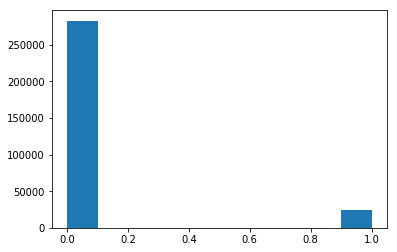

In [8]:
y = data['train']['TARGET']
plt.hist(y)
plt.show()

The label looks highly imbalanced. I use ROC AUC score as performance metric and it will be helpful for model validation. To perform feature engineering on training and testing data together, I concatened the two datasets.

In [9]:
df = pd.concat([data['train'],data['test']])
train_row = data['train'].shape[0]

__2. categorical features__

The nunique function has dropna=True as default, which is not what I want. I want to find the binary features for label encoding, if it contains NAN values, then OneHotEncoder will be more useful here.

In [37]:
# summary of categorical features
def cat_info(df):
    cat_f = df.select_dtypes(include = ['object']).apply(lambda x: x.nunique(dropna=False), axis = 0)
    return cat_f

cats = cat_info(df)

By examing the categorical features, I found some categorical data use 'XNA' instead of np.nan as NA values. So next I will replace 'XNA' as np.nan values.

In [11]:
# find 'XNA'
df.replace('XNA',np.nan,inplace = True)

In [23]:
# cat = cat_info(df)
# bin_f = cat[cat == 2].index
# bin_f

len(df['CODE_GENDER'].unique())

3

Some features are not categorical, but are also binary, so I will find these features in the numerical features. When apply aggregation functions, I do not want to contain the binary variables.

In [32]:
def bin_num(df):
    binary_f = []
    for c in df.columns:
        if len(df[c].unique())==2 and c not in bin_f:
            binary_f.append(c)
    return binary_f

bin_num = bin_num(df)

In [38]:
def cat_levels(df,cat_info):
    cat_f = df[cat_info.index]
    levels = {}
    for c in cat_f:
        level = list(df[c].unique())
        levels.update({c:level})
    return pd.DataFrame.from_dict(levels,orient='index')

cat_levels(df,cats)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57
CODE_GENDER,M,F,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
EMERGENCYSTATE_MODE,No,NaN,Yes,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
FLAG_OWN_CAR,N,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
FLAG_OWN_REALTY,Y,N,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
FONDKAPREMONT_MODE,reg oper account,NaN,org spec account,reg oper spec account,not specified,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
HOUSETYPE_MODE,block of flats,NaN,terraced house,specific housing,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
NAME_CONTRACT_TYPE,Cash loans,Revolving loans,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
NAME_EDUCATION_TYPE,Secondary / secondary special,Higher education,Incomplete higher,Lower secondary,Academic degree,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
NAME_FAMILY_STATUS,Single / not married,Married,Civil marriage,Widow,Separated,Unknown,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
NAME_HOUSING_TYPE,House / apartment,Rented apartment,With parents,Municipal apartment,Office apartment,Co-op apartment,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


From the above information of categorical features, I found 'WEEKDAY_APPR_PROCESS_START' is a feature may be encoded by LabelEncoder, but I still chosed to use OneHotEncoding to avoid possible missing feature characteristics.

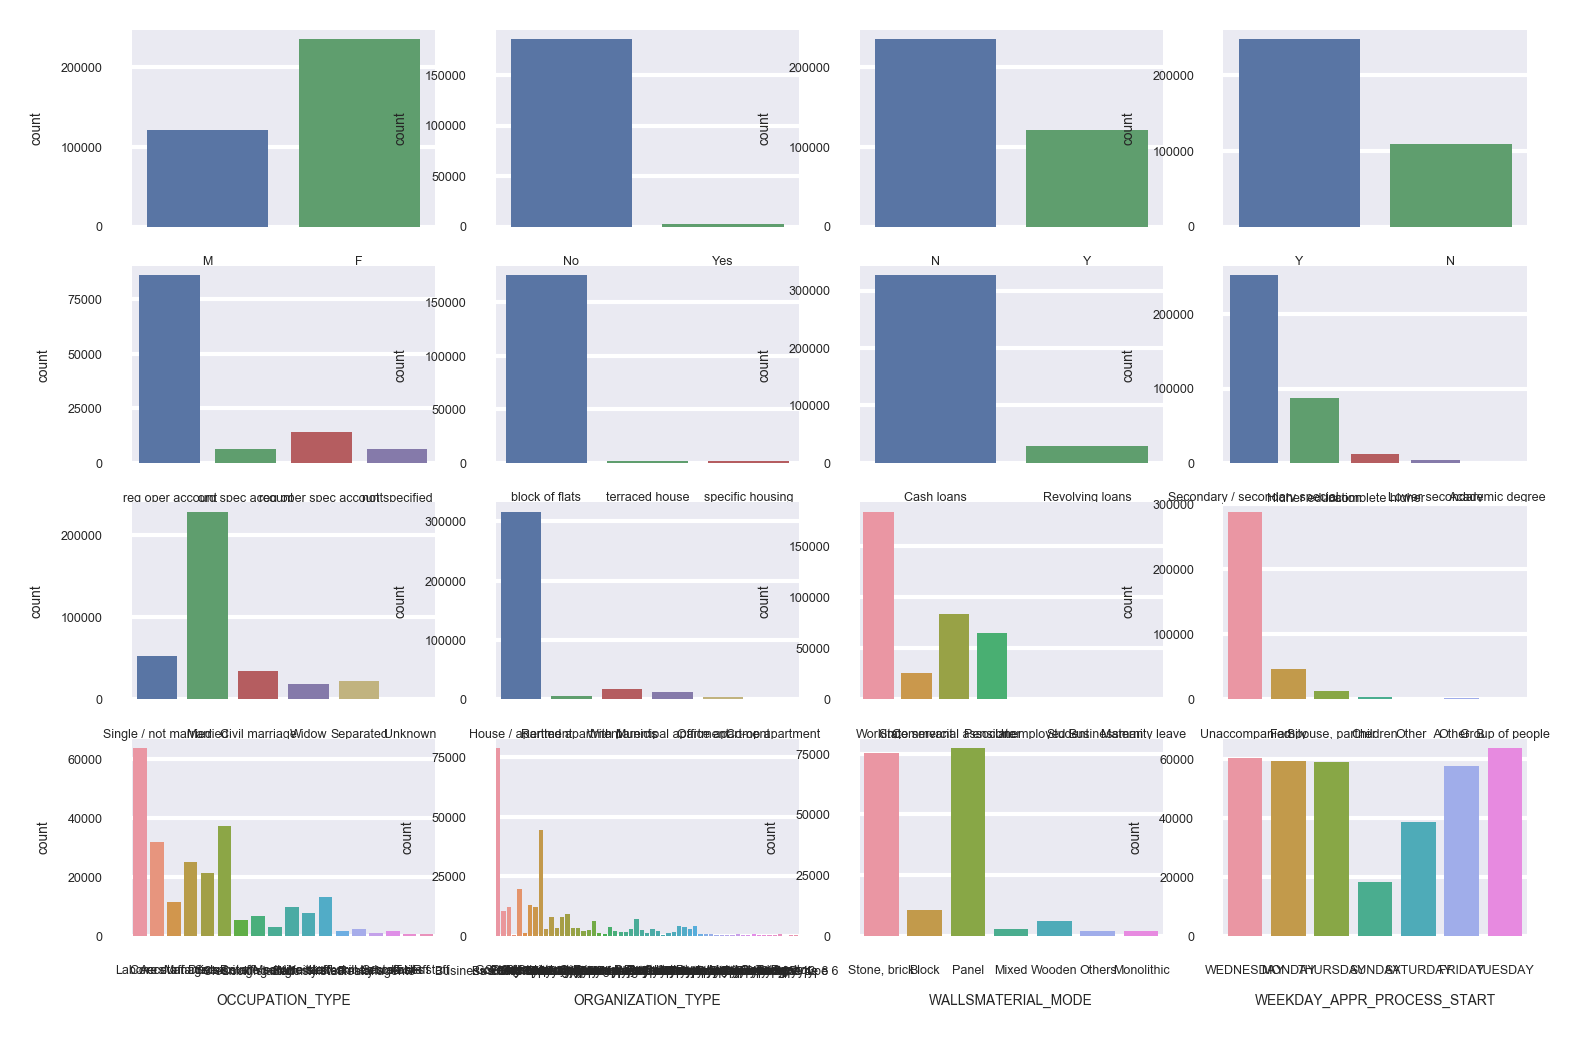

In [132]:
# percentage distribution of categorical features' categories
%matplotlib inline

plt.rcParams['figure.dpi'] = 300

# plt.figure(figsize=(20,10))
fig, ax = plt.subplots(4,4)

for i in range(len(cat)):
    c = cat['Categorical features'][i]
    row = i//4
    col = i%4
    sns.countplot(x=c, data=df,ax = ax[row,col])
    sns.set(font_scale = 0.5)

plt.show()

__2. numerical features__

In [39]:
# find aberrant numerical features
def num_abberrant(df):
    num_df = df.describe()
    abb = []
    for n in num_df.columns:
        low = num_df[n]['mean']-3*num_df[n]['std']
        up = num_df[n]['mean']+3*num_df[n]['std']
        if num_df[n]['min'] < low or num_df[n]['max'] > up:
            abb.append(n)
    return num_df[abb]

num_abb = num_abberrant(df.drop(bin_num,axis=1))
num_abb

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,CNT_CHILDREN,CNT_FAM_MEMBERS,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMAX_MODE,FLOORSMIN_AVG,FLOORSMIN_MEDI,FLOORSMIN_MODE,HOUR_APPR_PROCESS_START,LANDAREA_AVG,LANDAREA_MEDI,LANDAREA_MODE,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_AVG,NONLIVINGAREA_MEDI,NONLIVINGAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OWN_CAR_AGE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT_W_CITY,TARGET,TOTALAREA_MODE,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
count,356219.000000,3.562550e+05,3.559770e+05,3.562550e+05,308687.000000,308687.000000,308687.000000,308687.000000,308687.000000,308687.000000,176307.000000,176307.000000,176307.000000,148671.000000,148671.000000,148671.000000,356255.000000,356253.000000,107895.000000,107895.000000,107895.000000,356254.000000,356255.000000,355205.000000,355205.000000,167175.000000,167175.000000,167175.000000,177848.000000,177848.000000,177848.000000,179914.000000,179914.000000,179914.000000,115147.000000,115147.000000,115147.000000,356255.000000,145411.000000,145411.000000,145411.000000,113276.000000,113276.000000,113276.000000,178353.000000,178353.000000,178353.000000,109394.000000,109394.000000,109394.000000,160489.000000,160489.000000,160489.000000,355205.000000,355205.000000,121014.000000,356255.000000,356255.000000,307511.000000,185200.000000,183392.000000,183392.000000,183392.000000,119949.000000,119949.000000,119949.000000
mean,27425.560657,5.877674e+05,5.280200e+05,1.701161e+05,0.006281,0.005808,0.231697,0.304399,0.029995,1.911564,0.118138,0.118549,0.114914,0.088673,0.088178,0.087750,0.414316,2.151858,0.045045,0.044994,0.042930,-978.580852,-4983.593527,0.143452,0.100198,0.079819,0.078930,0.075346,0.150015,0.149494,0.145471,0.227331,0.226922,0.223315,0.232817,0.232504,0.228878,12.055749,0.066454,0.067296,0.065092,0.101495,0.102674,0.106382,0.108089,0.109279,0.106641,0.008868,0.008697,0.008116,0.028503,0.028386,0.027183,1.425729,1.409468,12.023741,0.020917,2.028932,0.080729,0.103193,0.977889,0.977903,0.977239,0.752283,0.755548,0.759452
std,14732.808190,3.986237e+05,3.660650e+05,2.235068e+05,0.104250,0.079736,0.855949,0.786915,0.191374,1.865338,0.108954,0.109824,0.108745,0.082312,0.082017,0.084076,0.720378,0.907937,0.077045,0.077140,0.075437,835.063902,3526.968986,0.456579,0.368259,0.135249,0.135133,0.133025,0.100139,0.100450,0.101088,0.145051,0.145453,0.144126,0.161909,0.162419,0.161725,3.267576,0.081287,0.082267,0.081911,0.093418,0.094541,0.098779,0.111194,0.112881,0.112555,0.047876,0.047519,0.046330,0.069880,0.070574,0.070723,2.599914,2.577724,11.880848,0.013915,0.504586,0.272419,0.108041,0.057929,0.058562,0.063165,0.113267,0.112057,0.110112
min,1615.500000,4.500000e+04,4.050000e+04,2.565000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-4361.000000,-24672.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000253,-1.000000,0.000000,0.000000,0.000000,0.000000,0

In [40]:
num_abb.shape

(8, 66)

The above summary screened out 92 'abberrant' numerical features. I find a lot of features are actually binary, so I need to put these features in the binary features categories. So I go back and add a __bin_num__ function and change the input of __num_abberrant__ function. After that, the number of 'abberrant' features goes down to 66. From these changes, I find it most useful to go through each feature one by one.

In [41]:
# load data description
description = pd.read_csv('../input/HomeCredit_columns_description.csv',encoding = "cp1252")

In [43]:
dp_app = description[description['Table'] == 'application_{train|test}.csv'].iloc[:,2:]
dp_app.head()

,Row,Description,Special
0,SK_ID_CURR,ID of loan in our sample,NaN
1,TARGET,Target variable (1 - client with payment diffi...,NaN
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,CODE_GENDER,Gender of the client,NaN
4,FLAG_OWN_CAR,Flag if the client owns a car,NaN


To start with these 122 features, I group them by the 'Special' column.

In [44]:
dp_app['Special'].unique()

array([nan, 'normalized ', 'time only relative to the application',
       'rounded', 'normalized'], dtype=object)

In [45]:
normalized_f = dp_app['Row'][dp_app['Special'] == 'normalized']
# I find 'REGION_POPULATION_RELATIVE' is also normalized data but is not picked up by the algorithm
# append 'REGION_POPULATION_RELATIVE' to normalized features
normalized_f = list(normalized_f.append(dp_app['Row'][dp_app['Special'] == 'normalized ']))

In [46]:
time_to_app_f = list(dp_app['Row'][dp_app['Special'] == 'time only relative to the application'])
rounded_f = list(dp_app['Row'][dp_app['Special'] == 'rounded'])
other_f = list(dp_app['Row'][dp_app['Special'].isnull()])

In [47]:
# make sure all features are included
len(normalized_f) + len(time_to_app_f) + len(rounded_f) + len(other_f) == len(dp_app)

True

In [49]:
normal_num_f = [f for f in normalized_f if f not in cats.index]
time_num_f = [f for f in time_to_app_f if f not in cats.index]
round_num_f = [f for f in rounded_f if f not in cats.index]
other_num_f = [f for f in other_f if f not in cats.index]

In [50]:
# all values in normalized data should be in [0,1]
def norm_abb(df):
    norm_abb = []
    for c in df.columns:
        if df[c].dropna().between(0,1).all() == False:
            print('Values of column ' + c + ' not in range [0,1].')
            norm_abb.append(c)
    return norm_abb

norm_abb(df[normal_num_f])

[]

In [51]:
# all values in 'time only relative to the application' data should be negative
def time_abb(df):
    time_abb = []
    for c in df.columns:
        if df[c].dropna().le(0).all() == False:
            print('Values of column ' + c + ' has value greater than 0.')
            time_abb.append(c)
    return time_abb

time_abb(df[time_num_f])

Values of column DAYS_EMPLOYED has value greater than 0.


['DAYS_EMPLOYED']

In [55]:
df['DAYS_EMPLOYED'].head()

0    -637
1   -1188
2    -225
3   -3039
4   -3038
Name: DAYS_EMPLOYED, dtype: int64

In [57]:
df['DAYS_EMPLOYED'].replace(365243,np.nan,inplace=True)

In [58]:
# all values in 'time only relative to the application' data should be negative
def round_abb(df):
    round_abb = []
    for c in df.columns:
        if df[c].dropna().dtype != int:
            print('Values of column ' + c + ' has value greater than 0.')
            round_abb.append(c)
    return round_abb

round_abb(df[round_num_f])

[]

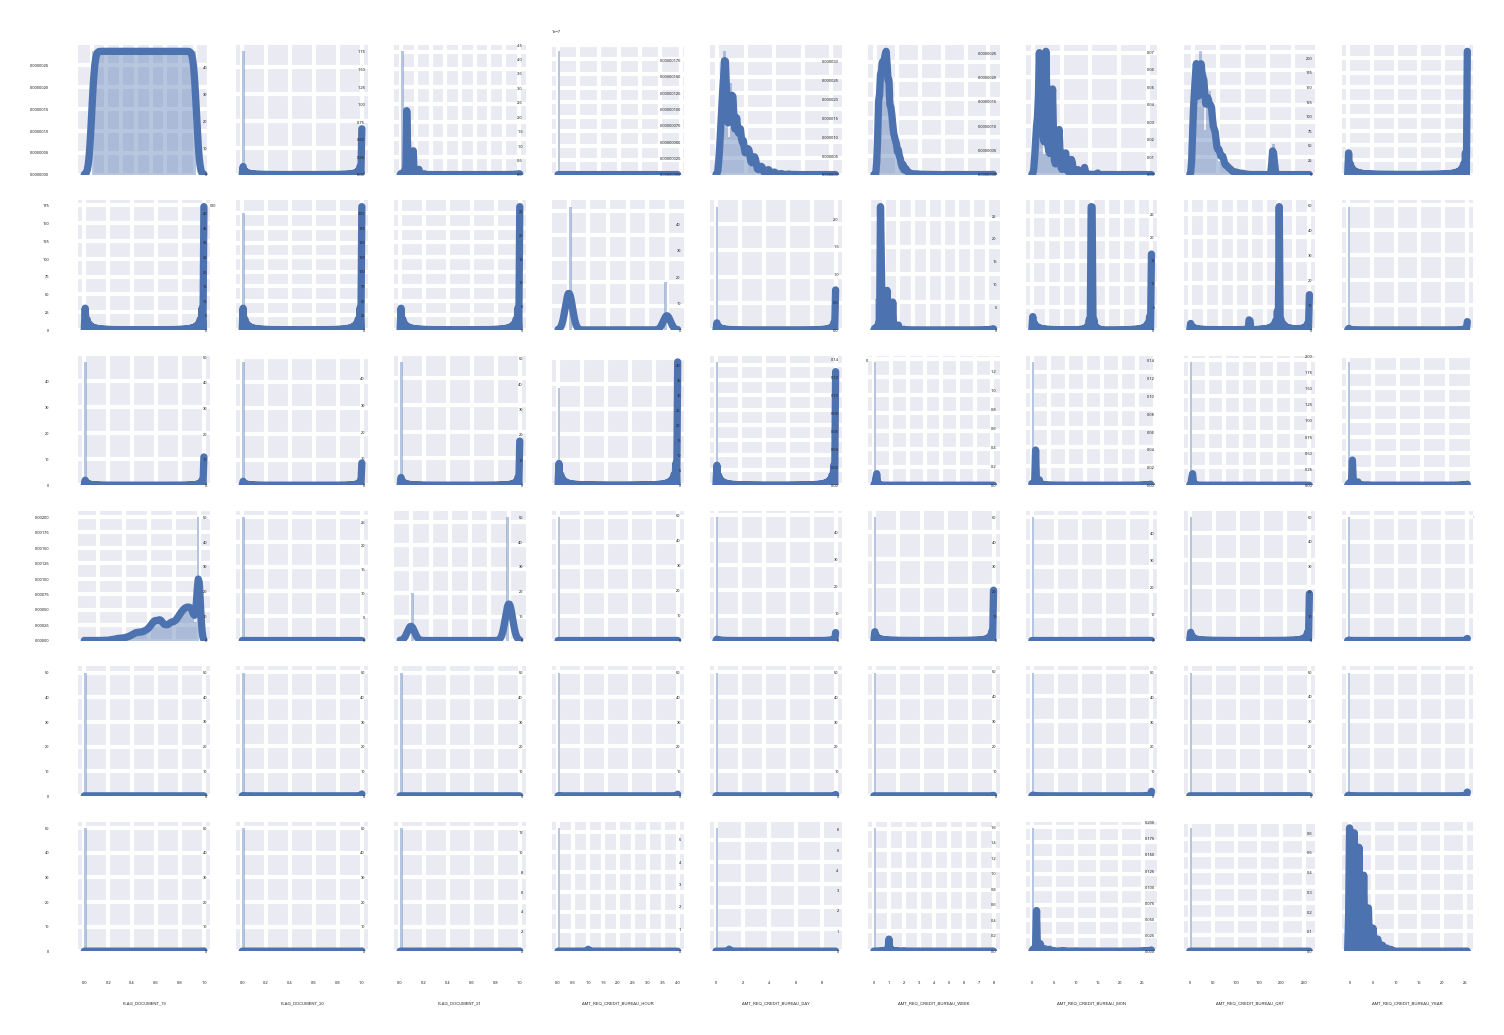

In [66]:
# distribution plot
%matplotlib inline

plt.rcParams['figure.dpi'] = 300

def sns_distplot(df,r,c,font_scale):
    fig, axs = plt.subplots(r,c)
    for i in range(df.shape[1]):
        row = i//c
        col = i%c
        sns.distplot(df.iloc[:,i].dropna(),ax = axs[row,col])
        sns.set(font_scale=font_scale)
    plt.show()

other_num = df[other_num_f]
sns_distplot(other_num,6,9,0.01)